The code in this notebook is based on [Richard Liao's implementation of hierarchical attention networks](https://github.com/richliao/textClassifier/blob/master/textClassifierHATT.py) and a related [Google group discussion](https://groups.google.com/forum/#!topic/keras-users/IWK9opMFavQ). The notebook also includes code from [Keras documentation](https://keras.io/) and [blog](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) as well as this [word2vec tutorial](http://adventuresinmachinelearning.com/gensim-word2vec-tutorial/).

To enable Theano to run on a single GPU: 

* check the following dependencies: 

  `conda install pygpu`
  

* Replace $HOME/.theanorc with this:
```
[global]
floatX = float32
device = gpu0
[lib]
gpuarray.preallocate=1
```

In [1]:
import os 
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu0'
os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/cuda-8.0/bin'
import theano
print(theano.config.device) 

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


gpu0


In [4]:
import gzip
import numpy as np
import pandas as pd
from collections import defaultdict
import os 
os.environ['KERAS_BACKEND'] = 'theano'
import requests
import subprocess
import time

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger

Download the Amazon reviews data for food from the Internet archive 
[J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013]

In [5]:
r = requests.get("https://archive.org/download/amazon-reviews-1995-2013/Gourmet_Foods.txt.gz")
with open("Gourmet_Foods.txt.gz", 'wb') as fp:
    fp.write(r.content)

In [6]:
with gzip.open("Gourmet_Foods.txt.gz", "rb") as fp:
    file_content = fp.read()
s = file_content.decode()

In [7]:
with open("Gourmet_Foods.txt", "w") as fp:
    fp.write(s)

In [8]:
lst = s.split('\n')

Extract scores and review texts from file 

In [9]:
text_lst = lst[9:len(lst):11]
score_lst = lst[6:len(lst):11]
score_lst2 = [sc[14:17] for sc in score_lst]
text_lst2 = [txt[13:] for txt in text_lst]

In [10]:
all_data = pd.DataFrame(data={'text': text_lst2, 'rating': score_lst2})
all_data.loc[:, 'rating'] = all_data['rating'].astype(float)
all_data.loc[:, 'rating'] = all_data['rating'].astype(int)

Remove medium ratings and convert to binary classification (high vs. low rating).  

In [11]:
all_data = all_data[all_data['rating'].isin([1, 5])]

In [12]:
new_data = all_data.replace({'rating': {1: '0', 5: '1'}})
new_data.loc[:, 'rating'] = new_data['rating'].astype(int)

Extract a balanced subsample and split into training and test sets.

In [13]:
sample_data = pd.concat([new_data[new_data.rating == 0].sample(10000), new_data[new_data.rating == 1].sample(10000)])
shuffled = sample_data.iloc[np.random.permutation(20000), :]
train_data = shuffled.iloc[:10000, :]
test_data = shuffled.iloc[10000:, :]

In [14]:
train_data.rating.value_counts()

0    5017
1    4983
Name: rating, dtype: int64

In [15]:
test_data.rating.value_counts()

1    5017
0    4983
Name: rating, dtype: int64

Set the dimensions of the input and the embedding. Because of the hierarchical nature of the network, the input has to be a 3-dimensional tensor of fixed size (sample_size x n_sentences x n_words). 

MAX_SENT_LEN : the number of words in each sentence. 

MAX_SENTS : the number of sentences in each document.

Longer documents and sentences will be truncated, shorter ones will be padded with zeros. These numbers should not be much larger than the average sentence and document lengths in the data.    

MAX_NB_WORDS : the size of the word encoding (number of most frequent words to keep in the vocabulary)

EMBEDDING_DIM : the dimensionality of the word embedding

In [334]:
MAX_SENT_LENGTH = 50
MAX_SENTS = 15
MAX_NB_WORDS = 6000
EMBEDDING_DIM = 100

Fit a Keras tokenizer to the most frequent words using the entire training data set as the corpus.
Create the training data in the 3d format required. 

In [335]:
import nltk 

nltk.download('punkt')

reviews = []
labels = []
texts = []

for idx in range(train_data.shape[0]):
    text = train_data['text'].iloc[idx]
    texts.append(text)
    sentences = nltk.tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(train_data['rating'].iloc[idx])

[nltk_data] Downloading package punkt to /home/anargyri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [336]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [337]:
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
doc_lst = []

# keep the MAX_NB_WORDS most frequent words and replace the rest with 'UNK'
# truncate to the first MAX_SENTS sentences per doc and MAX_SENT_LENGTH words per sentence

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            words_in_sent = []
            for _, word in enumerate(wordTokens):
                if k < MAX_SENT_LENGTH: 
                    if (word in tokenizer.word_index) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        words_in_sent.append(word)
                    else:
                        data[i, j, k] = MAX_NB_WORDS
                        words_in_sent.append('UNK')
                    k = k + 1
            doc_lst.append(words_in_sent)

Convert the ratings to one-hot categorical labels.

In [338]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

y_train = to_categorical(np.asarray(labels))
x_train = data

print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

Total 22846 unique tokens.
Shape of data tensor: (10000, 15, 50)
Shape of label tensor: (10000, 2)


In [339]:
n_classes = y_train.shape[1]

Train word2vec on the training documents in order to initialize the word embedding. Ignore rare words (min_count=3). Use skip-gram as the training algorithm (sg=1).

In [340]:
# train word2vec on the sentences to initialize the word embedding 
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# use skip-gram
word2vec_model = gensim.models.Word2Vec(doc_lst, min_count=3, size=EMBEDDING_DIM, sg=1, workers=os.cpu_count())

2017-09-22 18:38:39,323 : INFO : collecting all words and their counts
2017-09-22 18:38:39,324 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-09-22 18:38:39,355 : INFO : PROGRESS: at sentence #10000, processed 146812 words, keeping 5370 word types
2017-09-22 18:38:39,388 : INFO : PROGRESS: at sentence #20000, processed 294232 words, keeping 5871 word types
2017-09-22 18:38:39,423 : INFO : PROGRESS: at sentence #30000, processed 441636 words, keeping 5976 word types
2017-09-22 18:38:39,454 : INFO : PROGRESS: at sentence #40000, processed 591218 words, keeping 5991 word types
2017-09-22 18:38:39,475 : INFO : collected 5997 word types from a corpus of 694642 raw words and 46940 sentences
2017-09-22 18:38:39,476 : INFO : Loading a fresh vocabulary
2017-09-22 18:38:39,490 : INFO : min_count=3 retains 5984 unique words (99% of original 5997, drops 13)
2017-09-22 18:38:39,491 : INFO : min_count=3 leaves 694622 word corpus (99% of original 694642, drops 20)
201

Create the initial embedding matrix from the output of word2vec.

In [341]:
embeddings_index = {}

for word in word2vec_model.wv.vocab:
    coefs = np.asarray(word2vec_model.wv[word], dtype='float32')
    embeddings_index[word] = coefs

print('Total %s word vectors.' % len(embeddings_index))

Total 5984 word vectors.


In [342]:
# Initial embedding
embedding_matrix = np.zeros((MAX_NB_WORDS + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < MAX_NB_WORDS:
        embedding_matrix[i] = embedding_vector
    elif i == MAX_NB_WORDS:
        # index MAX_NB_WORDS in data corresponds to 'UNK'
        embedding_matrix[i] = embeddings_index['UNK']

Define the network.
The mask_zero option determines whether masking is performed, i.e. whether the layers ignore the padded zeros in shorter documents.

In [352]:
# building Hierachical Attention network

REG_PARAM = 1e-10
l2_reg = regularizers.l2(REG_PARAM)

embedding_layer = Embedding(MAX_NB_WORDS + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SENT_LENGTH,
                            trainable=True,
                            mask_zero=True,
                            embeddings_regularizer=l2_reg,
                            weights=[embedding_matrix])

Define a custom layer implementing the attention mechanism.

In [353]:
CONTEXT_DIM = 100

class AttLayer(Layer):
    def __init__(self, regularizer=None, **kwargs):
        self.regularizer = regularizer
        self.supports_masking = True
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3        
        self.W = self.add_weight(name='W', shape=(input_shape[-1], CONTEXT_DIM), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.b = self.add_weight(name='b', shape=(CONTEXT_DIM,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.u = self.add_weight(name='u', shape=(CONTEXT_DIM,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)        
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = K.dot(K.tanh(K.dot(x, self.W) + self.b), self.u)
        ai = K.exp(eij)
        alphas = ai / K.sum(ai, axis=1).dimshuffle(0, 'x')
        if mask is not None:
            # use only the inputs specified by the mask
            alphas *= mask
        weighted_input = x * alphas.dimshuffle(0, 1, 'x')
        return weighted_input.sum(axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def get_config(self):
        config = {}
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask):
        return None

GRU_UNITS is the dimensionality of each GRU output (the number of GRU units). GRU_IMPL = 2 selects a matricized RNN implementation which is more appropriate for training on a GPU. 

There are two levels of models in the definition. The sentence model `sentEncoder` is shared across all sentences in the input document.   

In [354]:
GPU_IMPL = 2          
GRU_UNITS = 100        

sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(GRU_UNITS, return_sequences=True, kernel_regularizer=l2_reg, 
                           implementation=GPU_IMPL))(embedded_sequences)
l_att = AttLayer(regularizer=l2_reg)(l_lstm)            
sentEncoder = Model(sentence_input, l_att)

review_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(GRU_UNITS, return_sequences=True, kernel_regularizer=l2_reg, 
                                implementation=GPU_IMPL))(review_encoder)
l_att_sent = AttLayer(regularizer=l2_reg)(l_lstm_sent)       
preds = Dense(n_classes, activation='softmax', kernel_regularizer=l2_reg)(l_att_sent)
model = Model(review_input, preds)

In [355]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.8, nesterov=True),
              metrics=['acc'])

In [356]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 15, 50)            0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 200)           740900    
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 15, 200)           180600    
_________________________________________________________________
att_layer_32 (AttLayer)      (None, 200)               20200     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 402       
Total params: 942,102
Trainable params: 942,102
Non-trainable params: 0
_________________________________________________________________


In [357]:
fname = 'han_food'
history = History()
csv_logger = CSVLogger('./{0}_{1}.log'.format(fname, REG_PARAM), separator=',', append=True)

Order training data by the number of sentences in document (as suggested in the [Yang et al.] paper).

In [358]:
doc_lengths = [len(r) for r in reviews]
ind = np.argsort(doc_lengths)

In [359]:
BATCH_SIZE = 50
NUM_EPOCHS = 20

In [360]:
t1 = time.time()

model.fit(x_train[ind,:,:], y_train[ind,:], epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, shuffle=False, 
          callbacks=[history, csv_logger], verbose=2)

t2 = time.time()

Epoch 1/20
58s - loss: 0.6869 - acc: 0.5516
Epoch 2/20
57s - loss: 0.6629 - acc: 0.6292
Epoch 3/20
57s - loss: 0.4835 - acc: 0.7710
Epoch 4/20
57s - loss: 0.3469 - acc: 0.8512
Epoch 5/20
57s - loss: 0.2877 - acc: 0.8860
Epoch 6/20
57s - loss: 0.2561 - acc: 0.8969
Epoch 7/20
57s - loss: 0.2222 - acc: 0.9151
Epoch 8/20
57s - loss: 0.1908 - acc: 0.9288
Epoch 9/20
57s - loss: 0.1659 - acc: 0.9393
Epoch 10/20
57s - loss: 0.1517 - acc: 0.9473
Epoch 11/20
57s - loss: 0.1335 - acc: 0.9523
Epoch 12/20
57s - loss: 0.1370 - acc: 0.9499
Epoch 13/20
57s - loss: 0.1163 - acc: 0.9603
Epoch 14/20
57s - loss: 0.1138 - acc: 0.9615
Epoch 15/20
57s - loss: 0.0921 - acc: 0.9711
Epoch 16/20
57s - loss: 0.0962 - acc: 0.9688
Epoch 17/20
57s - loss: 0.0745 - acc: 0.9759
Epoch 18/20
57s - loss: 0.0713 - acc: 0.9779
Epoch 19/20
57s - loss: 0.0570 - acc: 0.9822
Epoch 20/20
57s - loss: 0.0491 - acc: 0.9861


In [361]:
test_reviews = []
test_labels = []
test_texts = []

for idx in range(test_data.shape[0]):
    text = test_data['text'].iloc[idx]
    test_texts.append(text)
    sentences = nltk.tokenize.sent_tokenize(text)
    test_reviews.append(sentences)
    test_labels.append(test_data['rating'].iloc[idx])

In [362]:
data2 = np.zeros((len(test_texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(test_reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            words_in_sent = []
            for _, word in enumerate(wordTokens):
                if k < MAX_SENT_LENGTH: 
                    if (word in tokenizer.word_index) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data2[i, j, k] = tokenizer.word_index[word]
                        words_in_sent.append(word)
                    else:
                        data2[i, j, k] = MAX_NB_WORDS
                        words_in_sent.append('UNK')
                    k = k + 1

In [363]:
y_test = to_categorical(np.asarray(test_labels))
x_test = data2

In [364]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [365]:
preds = model.predict(x_test)
print("Accuracy = {0} \t AUC = {1}".format(accuracy_score(test_labels, preds.argmax(axis=1)),
                                           roc_auc_score(test_labels, preds[:, 1])))

Accuracy = 0.8887 	 AUC = 0.9590876492256548


In [366]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


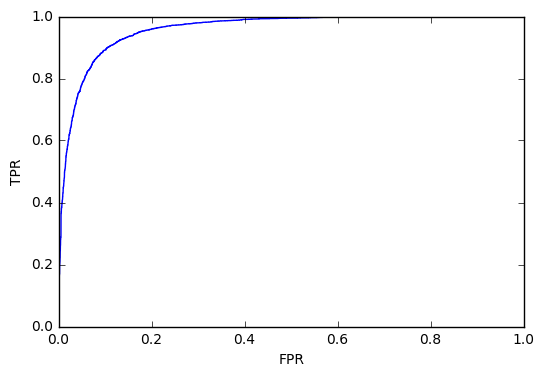

In [367]:
fpr, tpr, _ = roc_curve(test_labels, preds[:, 1])
plot(fpr, tpr)
xlabel('FPR')
ylabel('TPR')